# Introduction

This notebook will illustrate solution of the `lagaris_05` 2-D PDE BVP using TensorFlow.

## The `lagaris_05` PDE problem

This PDE was used as the fifth example problem in (Lagaris *et al.*, 1998). The differential equation is provided in the form (equation (32) in Lagaris *et al.* (1998)):

\begin{equation}
    \nabla^2 \psi (x,y) = e^{-x} \left( x - 2 + y^3 + 6y \right)
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y}, \frac {\partial^2 \psi} {dx^2} \frac {\partial^2 \psi} {\partial y^2} \right) = \frac {\partial^2 \psi} {\partial x^2} + \frac {\partial^2 \psi} {dy^2} - e^{-x} \left( x - 2 + y^3 + 6y \right) = 0
\end{equation}

with boundary conditions:

\begin{equation}
    f_0(0, y) = \psi(0, y) = y^3 \\
    f_1(1, y) = \psi(1, y) = ( 1 + y^3 ) e^{-1} \\
    g_0(x, 0) = \psi(x, 0) = x e^{-x} \\
    g_1(x, 1) = \psi(x, 1) = e^{-x} (x + 1)
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = e^{-x} (x + y^3)
\end{equation}

The 1st and 2nd partial derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = e^{-x} ( 1 - x - y^3) \\
    \frac {\partial \psi} {\partial y} = 3 e^{-x} y^2 \\
    \frac {\partial^2 \psi} {\partial x^2} = e^{-x} ( -2 + x + y^3) \\
    \frac {\partial^2 \psi} {\partial y^2} = 6 e^{-x} y
\end{equation}

The analytical solution in the domain $0 \leq x,y \leq 1$ is plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [3]:
# Import the problem definition.
eq_name = "lagaris_05"
eq_module = 'nnde.differentialequation.examples.lagaris_05'
eq = importlib.import_module(eq_module)

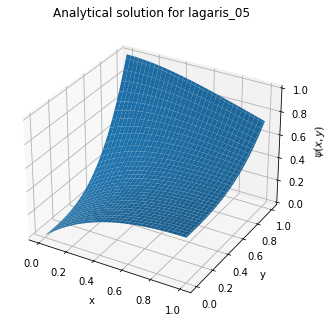

In [4]:
# Compute the analytical solution.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for y in ya] for x in xa]
Ya = np.array(Ya)

# Plot the analytical solution.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
Z = Ya.T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.title("Analytical solution for %s" % eq_name)
plt.show()

## Solving `lagaris_05` using TensorFlow

In [5]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [6]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [7]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [8]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        # activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [9]:
print_system_information()

System report:
2021-12-11 13:34:30.914498
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Tue Oct 12 18:33:42 PDT 2021; root:xnu-7195.141.8~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [10]:
# Set up the output directory.
path = "./lagaris_05"
output_dir = create_output_directory(path)

In [11]:
# Define the hyperparameters.

# Training optimizer
optimizer_name = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Relative tolerance for consecutive loss function values to indicate convergence.
tol = 1e-6

# Number of hidden nodes.
H = 10

# Number of training points in each dimension.
nx_train = 11
ny_train = 11
n_train = nx_train*ny_train

# Number of validation points in each dimension.
nx_val = 21
ny_val = 21
n_val = nx_val*ny_val

# Random number generator seed.
random_seed = 0

In [12]:
# Create and save the training data.
xy_train = create_training_data(nx_train, ny_train)
x_train = xy_train[::ny_train, 0]
y_train = xy_train[:ny_train, 1]
np.savetxt(os.path.join(output_dir,'xy_train.dat'), xy_train)

# Create and save the validation data.
xy_val = create_training_data(nx_val, ny_val)
x_val = xy_val[::ny_val, 0]
y_val = xy_val[:ny_val, 1]
np.savetxt(os.path.join(output_dir, 'xy_val.dat'), xy_val)

In [13]:
# Define the differential equation using TensorFlow operations.

@tf.function
def difeq(x, y, Y, dY_dx, dY_dy, d2Y_dx2, d2Y_dy2):
    G = d2Y_dx2 + d2Y_dy2 - tf.math.exp(-x)*(x - 2 + y**3 + 6*y)
    return G

In [14]:
# Define the trial function.

c1 = tf.constant(exp(-1.0), dtype=tf.float64)

@tf.function
def Y_trial(x, y, N):
    A = (
        (1 - x)*y**3
        + x*(1 + y**3)*c1
        + (1 - y)*x*(tf.math.exp(-x) - c1)
        + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*c1))
    )
    P = x*(1 - x)*y*(1 - y)
    Y = A + P*N[:, 0]
    return Y

2021-12-11 13:34:31.000629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model.

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
xy_train_v = tf.Variable(xy_train, name="xy_train")
xy = xy_train_v

# Clear the convergence flag to start.
converged = False

print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, optimizer = %s, learning_rate = %s"
      % (n_train, H, max_epochs, optimizer_name, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape(persistent=True) as tape1:

                # Extract individual variables for convenience.
                x = xy[:, 0]
                y = xy[:, 1]

                # Compute the network output.
                N = model(xy)

                # Compute the trial solution.
                Y = Y_trial(x, y, N)

            # Compute the gradient of the trial solution wrt inputs.
            delY = tape1.gradient(Y, xy)
            dY_dx = delY[:, 0]
            dY_dy = delY[:, 1]

        # Compute the Laplacian of trial solution wrt inputs.
        # Jacobian of (n, m) wrt (n, m) is (n, m, n, m).
        del2Y_jac = tape2.jacobian(delY, xy)
        # NOTE: This extraction is critical.
        d2Y_dx2 = tf.linalg.tensor_diag_part(del2Y_jac[:, 0, :, 0])
        d2Y_dy2 = tf.linalg.tensor_diag_part(del2Y_jac[:, 1, :, 1])

        # Compute the estimates of the differential equation.
        G = difeq(x, y, Y, dY_dx, dY_dy, d2Y_dx2, d2Y_dy2)

        # Compute the loss function.
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

    # Save the current loss.
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        loss_delta = losses[-1] - losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad = tape3.gradient(L, model.trainable_variables)

    # Save the parameters used in this epoch.
    phist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this epoch.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

    # if epoch % 100 == 0:
    print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last epoch.
phist.append(
    np.hstack(
        (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model.trainable_variables[1].numpy(),       # u (H,) row vector
         model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

n_epochs = epoch + 1

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % n_epochs)
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

Hyperparameters: n_train = 121, H = 10, max_epochs = 1000, optimizer = Adam, learning_rate = 0.01
Training started at 2021-12-11 13:34:35.302592


2021-12-11 13:34:35.652725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Ending epoch 0, loss function = 0.265722987947432
Ending epoch 1, loss function = 0.23658189213383568
Ending epoch 2, loss function = 0.20867079873227026
Ending epoch 3, loss function = 0.18278363178082038
Ending epoch 4, loss function = 0.160160341753222
Ending epoch 5, loss function = 0.14258390243600907
Ending epoch 6, loss function = 0.1320247101963661
Ending epoch 7, loss function = 0.1292759711893494
Ending epoch 8, loss function = 0.13263017331843174
Ending epoch 9, loss function = 0.1385479377765656
Ending epoch 10, loss function = 0.1437723655998459
Ending epoch 11, loss function = 0.14653989062465247
Ending epoch 12, loss function = 0.14639974049193696
Ending epoch 13, loss function = 0.14366811037737592
Ending epoch 14, loss function = 0.13904276273222219
Ending epoch 15, loss function = 0.13339737046030517
Ending epoch 16, loss function = 0.12766186666379337
Ending epoch 17, loss function = 0.12270665426403564
Ending epoch 18, loss function = 0.11918602217460862
Ending epoc

In [16]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        x = xy[:, 0]
        y = xy[:, 1]
        N = model(xy)
        Yt_train = Y_trial(x, y, N)
    delY = tape1.gradient(Yt_train, xy)
    dYt_dx_train = delY[:, 0]
    dYt_dy_train = delY[:, 1]
del2Y_jac = tape2.jacobian(delY, xy)
d2Yt_dx2_train = tf.linalg.tensor_diag_part(del2Y_jac[:, 0, :, 0])
d2Yt_dy2_train = tf.linalg.tensor_diag_part(del2Y_jac[:, 1, :, 1])
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train.numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dy_train.dat'), dYt_dy_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_train.dat'), d2Yt_dx2_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_train.dat'), d2Yt_dy2_train.numpy())

# Compute and save the analytical solution and derivatives at training points.
Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# Compute and save the error in the trained solution and derivatives at training points.
Yt_err_train = Yt_train.numpy() - Ya_train
dYt_dx_err_train = dYt_dx_train.numpy() - dYa_dx_train
dYt_dy_err_train = dYt_dy_train.numpy() - dYa_dy_train
d2Yt_dx2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dx2_train
d2Yt_dy2_err_train = d2Yt_dy2_train.numpy() - d2Ya_dy2_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

# Compute the final RMS errors.
Yt_rmse_train = np.sqrt(np.sum(Yt_err_train**2)/n_train)
print("Yt_rmse_train = %s" % Yt_rmse_train)

Yt_rmse_train = 6.604555682219662e-05


In [17]:
# Compute and save the trained results at validation points.
xy_val_var = tf.Variable(xy_val.reshape((n_val, 2)))
xy = xy_val_var
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        x = xy[:, 0]
        y = xy[:, 1]
        N = model(xy)
        Yt_val = Y_trial(x, y, N)
    delY = tape1.gradient(Yt_val, xy)
    dYt_dx_val = delY[:, 0]
    dYt_dy_val = delY[:, 1]
del2Y_jac = tape2.jacobian(delY, xy)
d2Yt_dx2_val = tf.linalg.tensor_diag_part(del2Y_jac[:, 0, :, 0])
d2Yt_dy2_val = tf.linalg.tensor_diag_part(del2Y_jac[:, 1, :, 1])
np.savetxt(os.path.join(output_dir, 'Yt_val.dat'), Yt_val.numpy().reshape((n_val)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_val.dat'), dYt_dx_val.numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dy_val.dat'), dYt_dy_val.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_val.dat'), d2Yt_dx2_val.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_val.dat'), d2Yt_dy2_val.numpy())

# Compute and save the analytical solution and derivatives at validation points.
Ya_val = np.array([eq.Ya(xy) for xy in xy_val])
dYa_dx_val = np.array([eq.dYa_dx(xy) for xy in xy_val])
dYa_dy_val = np.array([eq.dYa_dy(xy) for xy in xy_val])
d2Ya_dx2_val = np.array([eq.d2Ya_dx2(xy) for xy in xy_val])
d2Ya_dy2_val = np.array([eq.d2Ya_dy2(xy) for xy in xy_val])
np.savetxt(os.path.join(output_dir,'Ya_val.dat'), Ya_val)
np.savetxt(os.path.join(output_dir,'dYa_dx_val.dat'), dYa_dx_val)
np.savetxt(os.path.join(output_dir,'dYa_dy_val.dat'), dYa_dy_val)
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_val.dat'), d2Ya_dx2_val)
np.savetxt(os.path.join(output_dir,'d2Ya_dy2_val.dat'), d2Ya_dy2_val)

# Compute and save the error in the trained solution and derivatives at validation points.
Yt_err_val = Yt_val.numpy() - Ya_val
dYt_dx_err_val = dYt_dx_val.numpy() - dYa_dx_val
dYt_dy_err_val = dYt_dy_val.numpy() - dYa_dy_val
d2Yt_dx2_err_val = d2Yt_dx2_val.numpy() - d2Ya_dx2_val
d2Yt_dy2_err_val = d2Yt_dy2_val.numpy() - d2Ya_dy2_val
np.savetxt(os.path.join(output_dir, 'Yt_err_val.dat'), Yt_err_val)
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_val.dat'), dYt_dx_err_val)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_val.dat'), dYt_dy_err_val)
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_val.dat'), d2Yt_dx2_err_val)
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_val.dat'), d2Yt_dy2_err_val)

# Compute the final RMS errors.
Yt_rmse_val = np.sqrt(np.sum(Yt_err_val**2)/n_val)
print("Yt_rmse_val = %s" % Yt_rmse_val)

Yt_rmse_val = 6.92010900457364e-05


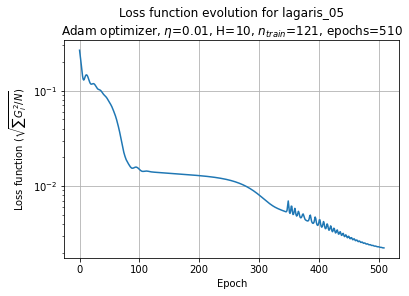

In [18]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

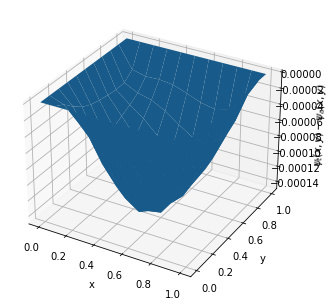

In [19]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = Yt_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

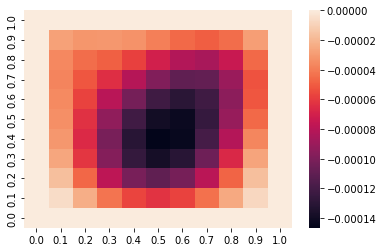

In [20]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

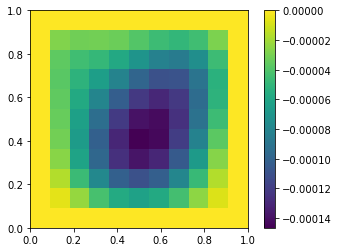

In [21]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

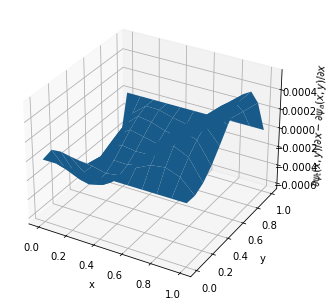

In [22]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dx_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial x-\partial \psi_a(x,y)/\partial x$')
plt.show()

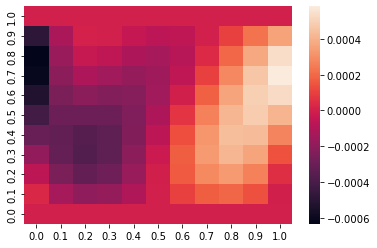

In [23]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

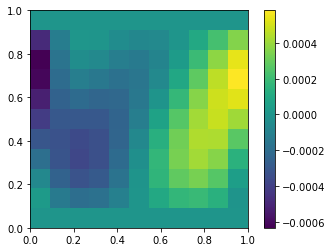

In [24]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

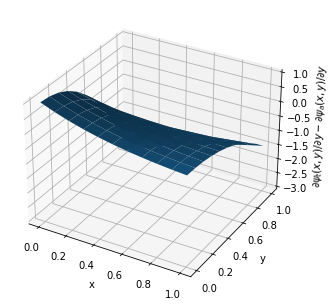

In [25]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dy_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial y-\partial \psi_a(x,y)/\partial y$')
plt.show()

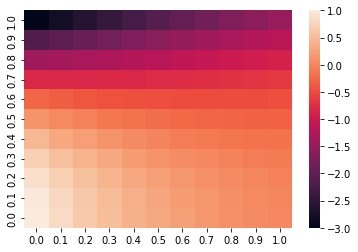

In [26]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

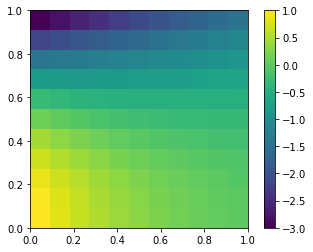

In [27]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

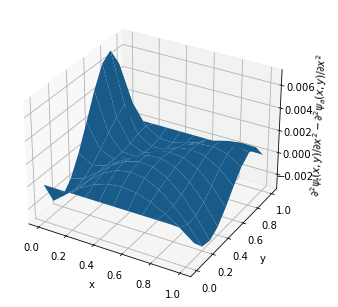

In [28]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

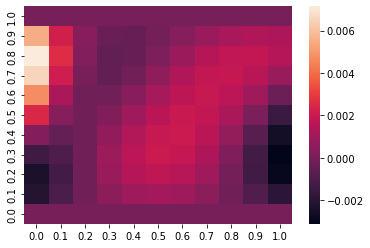

In [29]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

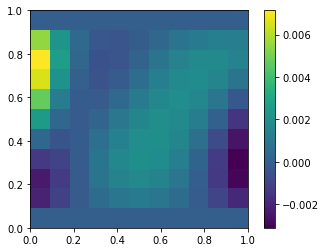

In [30]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

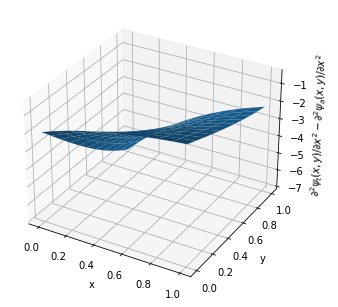

In [31]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

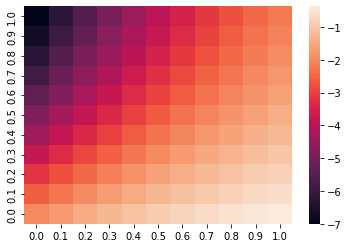

In [32]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

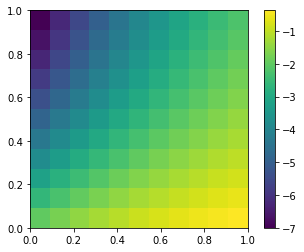

In [33]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

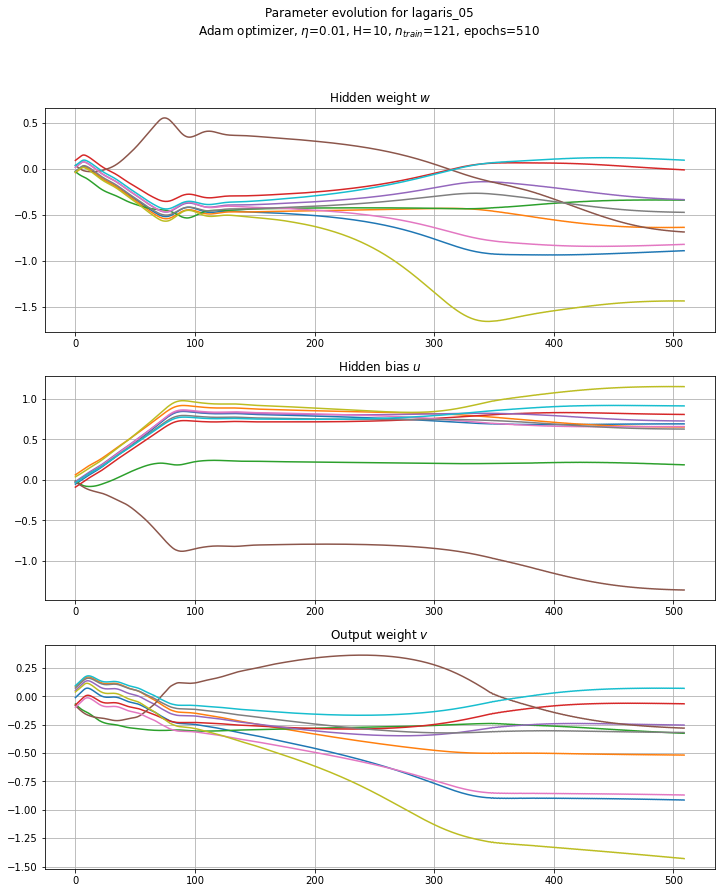

In [34]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, epoch + 1))
plt.subplots_adjust(hspace=0.2)
plt.show()